# Лабораторная работа "Численная интерполяция"

В этой лабораторной работе мы построим интерполянт выбранной функции разными методами.

Вспомогательный код:

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

clamp = lambda x, l, u: l if x < l else u if x > u else x

class GridFunction:
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n - 1
        self.h = (b - a) / self.n
        self.grid = {x : 0 for x in np.arange(a, b + self.h, self.h, dtype=float)}
        fig, self.ax = plt.subplots(figsize=(9, 6))
        self.ax.grid()

    def calc(self, func):
        for x in self.grid.keys():
            self.grid[x] = func(x)

    def plot(self, marker = '', label = '', title_str = ''):
        if label == '':
            self.ax.plot(self.grid.keys(), self.grid.values(), marker)
        else:
            self.ax.plot(self.grid.keys(), self.grid.values(), marker, label = label)
            self.ax.legend()
        
        self.ax.set(xlabel='x', ylabel='y', title=title_str)

class LagrangeInterpolant:
    def __init__(self, f):
        self.f = f
        self.n = len(f.grid)

        self.den = np.zeros(self.n)
        for k in range(self.n):
            self.den[k] = m.pow(f.h, 1 - self.n) * m.pow(-1, self.n - k - 1) / (m.factorial(k) * m.factorial(self.n - k - 1))
            
    
    def __call__(self, x):
        sum = 0

        for xk in self.f.grid.keys():
            l = 1
            k = int((xk - self.f.a) / self.f.h)

            for i in range(self.n):
                if i != k:
                    l *= x - self.f.a - self.f.h * i

            sum += l * self.den[k] * self.f.grid[xk]

        return sum

class NewtonInterpolant:
    def __init__(self, f):
        self.f = f
        self.n = len(f.grid) - 1

        self.divs = np.zeros(self.n + 1)
        for k in range(self.n + 2):
            for xj in list(self.f.grid.keys())[:k]:
                prod = 1
                for xi in list(self.f.grid.keys())[:k]:
                    if xj != xi:
                        prod *= xj - xi

                self.divs[k - 1] += self.f.grid[xj] / prod

    def __call__(self, x):
        sum = self.f.grid[self.f.a]

        for xk in self.f.grid.keys():
            k = int((xk - self.f.a) / self.f.h)
            prod = 1

            for i in range(k):
                prod *= x - self.f.a - self.f.h * i

            sum += prod * self.divs[k]

        return sum

def tridiagonal(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))

    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1]

    xc = bc
    xc[-1] = dc[-1] / bc[-1]

    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]

    return xc

class SplineInterpolant:
    def __init__(self, f):
        self.f = f
        self.n = len(f.grid) - 1

        self.a = np.array(list(self.f.grid.values()))

        d = np.zeros(self.n - 1)
        for i in range(self.n - 1):
            d[i] = 3 * (self.a[i] + self.a[i + 2] - 2 * self.a[i + 1]) / (self.f.h ** 2)

        a = np.ones(self.n - 1)
        b = np.ones(self.n - 1) * 4
        c = np.ones(self.n - 1)
        self.c = np.concatenate((np.array([0]), tridiagonal(a, b, c, d), np.array([0])))

        self.b = np.zeros(self.n)
        for i in range(self.n):
            self.b[i] = (self.a[i + 1] - self.a[i]) / self.f.h + (2 * self.c[i + 1] + self.c[i]) / 3 * self.f.h
        
        self.d = np.zeros(self.n)
        for i in range(self.n):
            self.d[i] = (self.c[i + 1] - self.c[i]) / self.f.h / 3

    def __call__(self, x):
        i = clamp(int((x - self.f.a) / self.f.h), 0, self.f.n - 1) + 1
        xi = self.f.a + self.f.h * i
        return self.a[i] + self.b[i - 1] * (x - xi) + self.c[i] * (x - xi) ** 2 + self.d[i - 1] * (x - xi) ** 3

В качестве функции возьмем синус на отрезке $[0, 2]$ и 5 его точек.

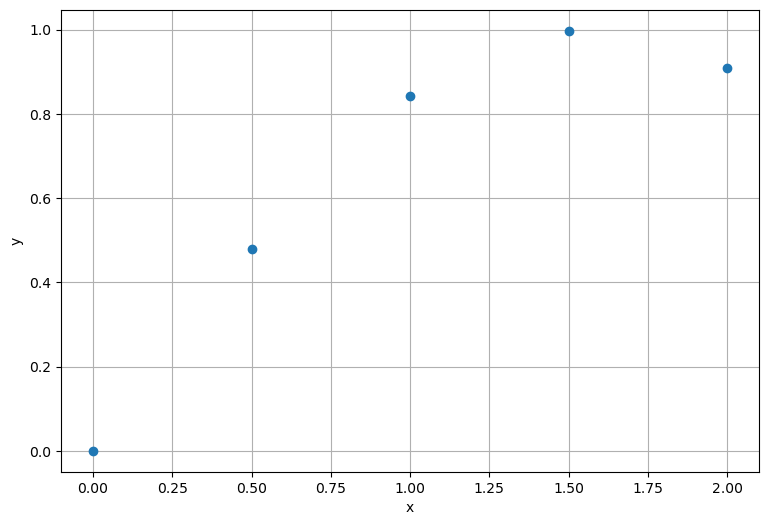

In [2]:
my_f = lambda x: m.sin(x)
n = 5
a, b = 0, 2

gf = GridFunction(a, b, n)
gf.calc(my_f)
gf.plot('o')

### Интерполянт Лагранжа

Будем использовать сеточную функцию с равным шагом. Тогда для полиномов Лагранжа
$$l_k(x) = \prod_{i = 1, i \neq k}^{n} \frac{x - x_i}{x_k - x_i} = \frac{\prod_{i = 1, i \neq k}^{n} (x - x_0 - ih)}{h^{n-1} \prod_{i = 1, i \neq k}^{n} (k - i)} = \prod_{i = 1, i \neq k}^{n} (x - x_0 - ih) \frac{h^{1-n}}{(k - 1)! (n - k)! (-1)^{k-n}}$$

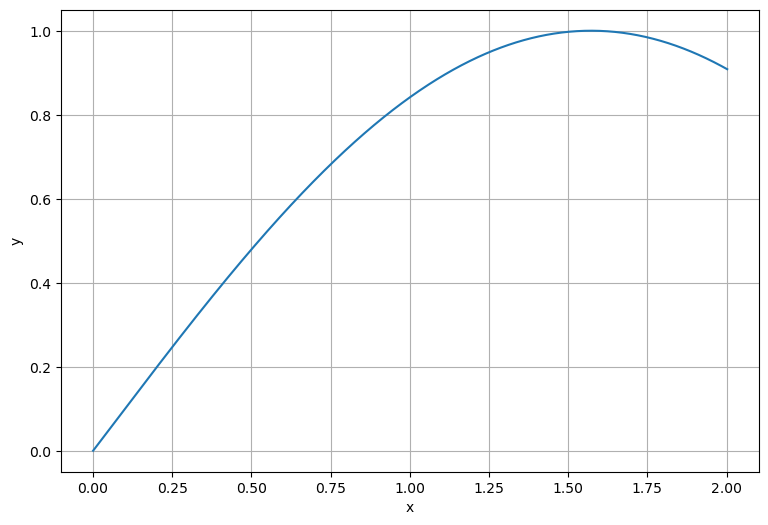

In [3]:
li = LagrangeInterpolant(gf)
ligf = GridFunction(a, b, 1000)
ligf.calc(li.__call__)
ligf.plot()

Найдем ошибку интерполяции
$$|f(x) - P_n(x)| \le |\frac{f^{(n)}(\xi)}{n!}(x - x_1)...(x - x_n)| = |\frac{(x - x_1)...(x - x_n)}{n!}| \text{ - для синуса}$$

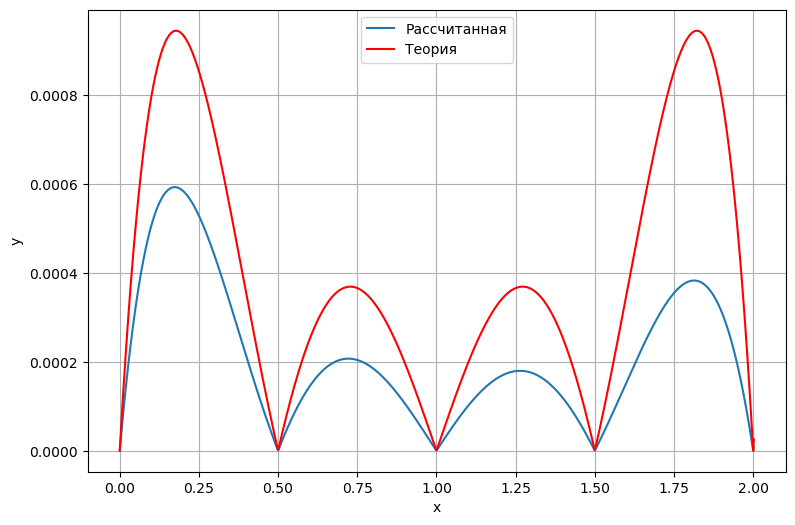

In [4]:
err_func = lambda x: m.fabs(my_f(x) - li(x))
errgf = GridFunction(a, b, 1000)
errgf.calc(err_func)
errgf.plot('-', 'Рассчитанная')

err_func = lambda x: m.fabs(np.prod([x - xi for xi in li.f.grid.keys()]) / m.factorial(n))
errgf.calc(err_func)
errgf.plot('r-', 'Теория')

### Интерполянт Ньютона

Для полиномов Ньютона $$P_n(x) = f(x_0) + (x - x_0)f(x_0;x_1) + (x - x_0)(x - x_1)f(x_0;x_1;x_2) + ... + (x - x_0)...(x - x_{n-1})f(x_0;...;x_n),$$ где $f(x_0;...;x_n)$ разделённая разность порядка $n$
$$f(x_j;x_{j+1};...;x_{j+k-1};x_{j+k}) = \frac{f(x_{j+1};...;x_{j+k-1};x_{j+k}) - f(x_j;x_{j+1};...;x_{j+k-1})}{x_{j+k}-x_j}$$
$$f(x_0;...;x_n) = \sum_{j = 0}^{n} \frac{f(x_j)}{\prod_{i = 0, i \neq j}^{n}(x_j-x_i)}$$

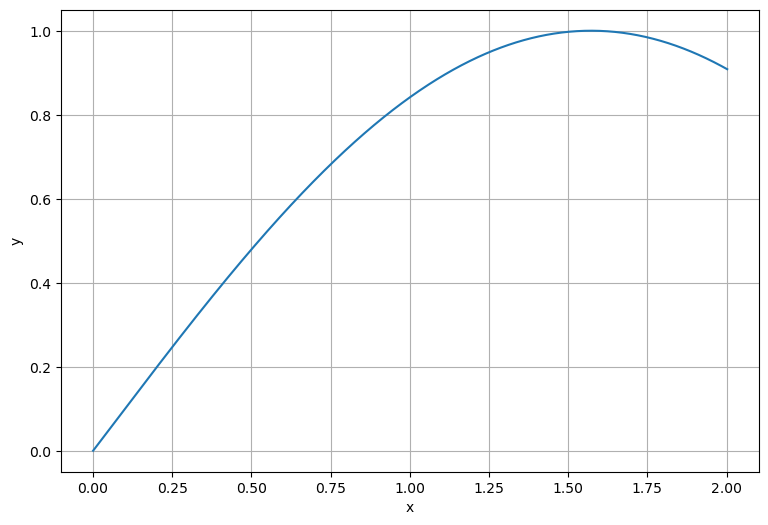

In [5]:
ni = NewtonInterpolant(gf)
nigf = GridFunction(a, b, 1000)
nigf.calc(ni.__call__)
nigf.plot()

Найдем ошибку интерполяции

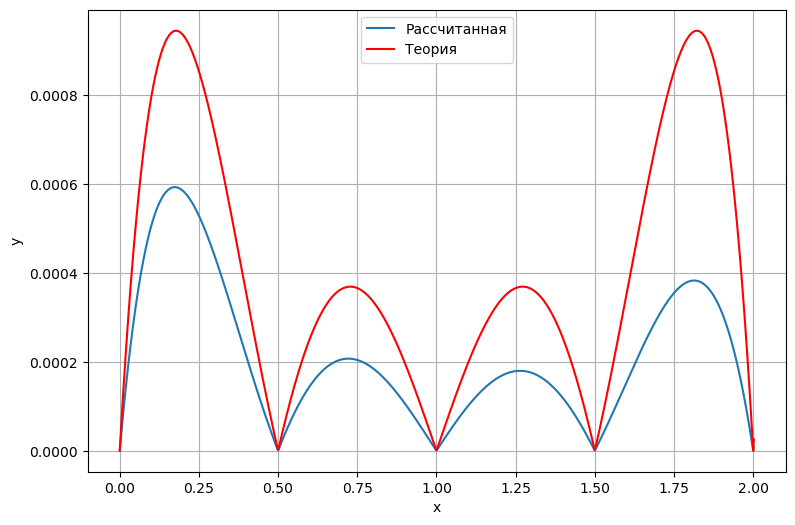

In [6]:
err_func = lambda x: m.fabs(my_f(x) - ni(x))
errgf = GridFunction(a, b, 1000)
errgf.calc(err_func)
errgf.plot('-', 'Рассчитанная')

err_func = lambda x: m.fabs(np.prod([x - xi for xi in ni.f.grid.keys()]) / m.factorial(n))
errgf.calc(err_func)
errgf.plot('r-', 'Теория')

### Кубические сплайны

На каждом отрезке $[x_{i-1}, x_i], i = \overline{1, n}$ функция $S(x)$ есть полином третьей степени $S_i(x)$, коэффициенты которого надо определить. Запишем для удобства $S_i(x)$ в виде:
$$S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3,$$ где $S_i(x_i) = f(x_i)$.
Обозначим: $h = x_i - x_{i-1}$
$\newline$
Из условий гладкости получаем для коэффициентов:
$a_i = f(x_i) \newline$
$b_i = \frac{a_i - a_{i-1}}{h} + \frac{2 c_i + c_{i-1}}{3}h \newline$
$d_i = \frac{c_i - c_{i-1}}{3h} \newline$
$c_{i-1} + 4c_i + c_{i+1} = 3\frac{a_{i+1} + a_{i-1} - 2a_i}{h^2} \newline$
причем $c_0 = c_n = 0$

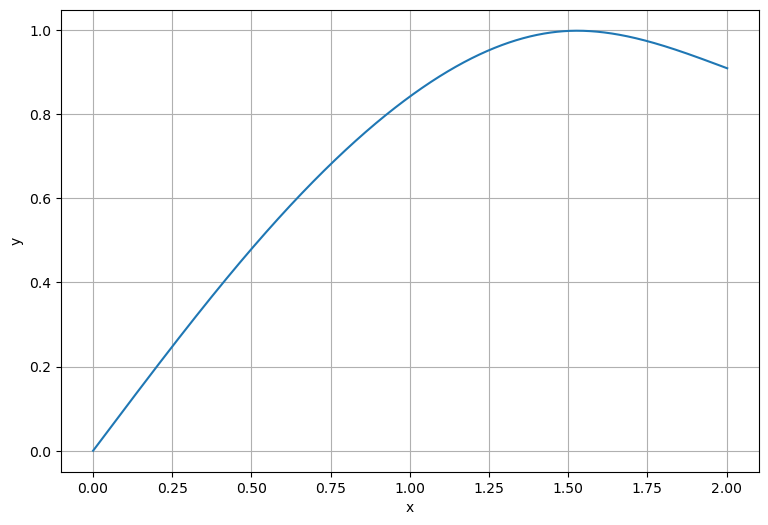

In [7]:
si = SplineInterpolant(gf)
sigf = GridFunction(a, b, 1000)
sigf.calc(si.__call__)
sigf.plot()

Найдем ошибку интерполяции

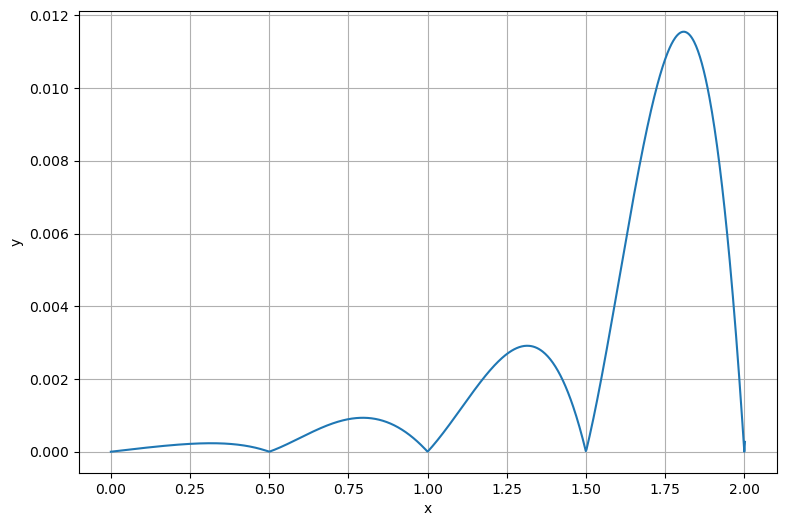

In [8]:
err_func = lambda x: m.fabs(my_f(x) - si(x))
errgf = GridFunction(a, b, 1000)
errgf.calc(err_func)
errgf.plot()